# (Spatial+Pixel) 증강 + KFold(K=5, epoch = 50)

# KFold

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-08-30 14:50:06.267233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:50:06.358735: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4 Physical GPUs, 4 Logical GPUs


2024-08-30 14:50:13.815875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:50:15.416100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-08-30 14:50:15.417174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-08-30 14:50:15.418122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

In [1]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [2]:
print(len(image_paths), len(image_labels))

925 925


# 원본 데이터에 바로 증강함수 적용

In [3]:
import numpy as np

# 이미지 경로와 라벨을 Numpy 배열로 변환
raw_x_train = np.array(image_paths)
raw_y_train = np.array(image_labels)

In [4]:
print("Train set:", len(raw_x_train))
print("Normal in Train set:", np.count_nonzero(raw_y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(raw_y_train == 1))

Train set: 925
Normal in Train set: 534
Abnormal in Train set: 391


In [6]:
import tensorflow as tf

2024-05-13 16:40:02.135483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 16:40:02.237386: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

def flip_H(image):
    return tf.image.flip_left_right(image)

def flip_V(image):
    return tf.image.flip_up_down(image)

def rotate(image):
    angle = random.uniform(0, 360)
    rotated = tf.image.rot90(image, k=int(angle // 90))
    return rotated

def CLAHE(image):
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) #2.0
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image

def RandomContrast(image):
    lower, upper = 0.5, 2.0 
    return tf.image.random_contrast(image, lower=lower, upper=upper)

def RandomBrightness(image):
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    image = image.numpy()
    kernel_size = random.choice([(5, 5), (7, 7), (9, 9), (13,13)])
    return cv2.blur(image, kernel_size)

normal_indices = [i for i, label in enumerate(raw_y_train) if label == 0] 
abnormal_indices = [j for j, label in enumerate(raw_y_train) if label == 1] 

selected_normal_images = [(raw_x_train[i]) for i in normal_indices] 
selected_normal_indexs = [(raw_y_train[i]) for i in normal_indices]
selected_abnormal_images = [(raw_x_train[j]) for j in abnormal_indices]
selected_abnormal_indexs = [(raw_y_train[j]) for j in abnormal_indices]

def load_and_preprocess_image(path, target_size=(250, 250)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image

aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate
}

aug_ratio_spatial = {
    'flip_H': 0.3,
    'flip_V': 0.3,
    'rotate': 0.4
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    'RandomContrast': RandomContrast,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
}

aug_ratio_pixel = {
    'CLAHE': 0.2,
    'RandomContrast': 0.2,
    'RandomBrightness': 0.3,
    'Blur': 0.3
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images

def apply_multiple_augmentations(image, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel):
    # 공간적 증강(spatial augmentation)을 먼저 적용
    spatial_funcs = list(aug_func_spatial.keys())
    spatial_probs = [aug_ratio_spatial[name] for name in spatial_funcs]
    spatial_choice = np.random.choice(spatial_funcs, p=spatial_probs)
    image = aug_func_spatial[spatial_choice](image)

    # 픽셀 기반 증강(pixel-based augmentation)을 적용
    pixel_funcs = list(aug_func_pixel.keys())
    pixel_probs = [aug_ratio_pixel[name] for name in pixel_funcs]
    pixel_choice = np.random.choice(pixel_funcs, p=pixel_probs)
    image = aug_func_pixel[pixel_choice](image)

    return image

random_select_normal = random.choices(selected_normal_images, k=466)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image) 
    augmented_image = apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel)
    aug_normal.append(augmented_image)

aug_normal_label = [0]*466

random_select_abnormal = random.choices(selected_abnormal_images, k=609)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.append(apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel))
    
aug_abnormal_label = [1]*609

2024-05-13 16:40:06.482072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 16:40:08.174346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-05-13 16:40:08.175361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12964 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-13 16:40:08.176282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localh

In [8]:
print(len(aug_normal))
print(len(aug_normal_label))
print(len(aug_abnormal))
print(len(aug_abnormal_label))

466
466
609
609


In [9]:
x_train = [load_and_preprocess_image(path) for path in raw_x_train]
y_train = np.array(raw_y_train)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size)
    
aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])
new_x_train = np.concatenate([x_train_resized, aug_normal_resized, aug_abnormal_resized])

print(len(new_x_train)) 
print(len(new_y_train))

2000
2000


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

k_splits = 5
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

accuracies = []

# K-Fold 교차 검증
with strategy.scope():
    for train_idx, test_idx in kf.split(new_x_train):
        train_images, test_images = new_x_train[train_idx], new_x_train[test_idx]
        train_labels, test_labels = new_y_train[train_idx], new_y_train[test_idx]

        # 모델 정의 및 컴파일
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(250, 250, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 모델 훈련
        model.fit(train_images, train_labels, epochs=50, verbose=1)

        # 예측 및 정확도 계산
        predictions = model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(test_labels, predicted_classes)
        accuracies.append(accuracy)

# 결과 출력
average_accuracy = np.mean(accuracies)
print(f"Average K-Fold Accuracy: {average_accuracy:.2f}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-05-13 15:43:11.782824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-13 15:43:13.967817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:43:14.853934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:43:15.720344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:43:16.098220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:43:16.148511: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 15:43:16.152672: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are us

 1/50 [..............................] - ETA: 12:33 - loss: 1.2928 - accuracy: 0.5312

2024-05-13 15:43:20.785357: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


50/50 [==============================] - 18s 44ms/step - loss: 1.0010 - accuracy: 0.5981
Epoch 2/50
50/50 [==============================] - 2s 45ms/step - loss: 0.9146 - accuracy: 0.5919
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7685 - accuracy: 0.6288
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7614 - accuracy: 0.6394
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6972 - accuracy: 0.6431
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7082 - accuracy: 0.6538
Epoch 7/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6453 - accuracy: 0.6731
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6471 - accuracy: 0.6631
Epoch 9/50
50/50 [==============================] - 2s 47ms/step - loss: 0.6306 - accuracy: 0.6669
Epoch 10/50
50/50 [==============================] - 2s 45ms/step - loss: 0.6174 - accuracy: 0.6669
Epoch 11/50
50/50 [

2024-05-13 15:45:22.118804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.9055 - accuracy: 0.5944
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7853 - accuracy: 0.6219
Epoch 3/50
50/50 [==============================] - 2s 50ms/step - loss: 0.7036 - accuracy: 0.6394
Epoch 4/50
50/50 [==============================] - 3s 51ms/step - loss: 0.6583 - accuracy: 0.6837
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6674 - accuracy: 0.6656
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6285 - accuracy: 0.6781
Epoch 7/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6062 - accuracy: 0.6862
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6732 - accuracy: 0.6288
Epoch 9/50
50/50 [==============================] - 2s 48ms/step - loss: 0.6442 - accuracy: 0.6338
Epoch 10/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6286 - accuracy: 0.6662
Epoch 11/50
50/50 [

2024-05-13 15:47:25.258333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.9320 - accuracy: 0.5913
Epoch 2/50
50/50 [==============================] - 2s 43ms/step - loss: 0.8698 - accuracy: 0.5919
Epoch 3/50
50/50 [==============================] - 2s 48ms/step - loss: 0.7649 - accuracy: 0.6344
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7435 - accuracy: 0.6463
Epoch 5/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6845 - accuracy: 0.6544
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6145 - accuracy: 0.6906
Epoch 7/50
50/50 [==============================] - 2s 45ms/step - loss: 0.6026 - accuracy: 0.7031
Epoch 8/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5833 - accuracy: 0.7144
Epoch 9/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5497 - accuracy: 0.7319
Epoch 10/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5659 - accuracy: 0.7169
Epoch 11/50
50/50 [

2024-05-13 15:49:28.061640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 43ms/step - loss: 1.1231 - accuracy: 0.5919
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7544 - accuracy: 0.6306
Epoch 3/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7705 - accuracy: 0.6350
Epoch 4/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7363 - accuracy: 0.6325
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6415 - accuracy: 0.6656
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6758 - accuracy: 0.6456
Epoch 7/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6886 - accuracy: 0.6244
Epoch 8/50
50/50 [==============================] - 2s 46ms/step - loss: 0.6831 - accuracy: 0.6219
Epoch 9/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6583 - accuracy: 0.6338
Epoch 10/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6374 - accuracy: 0.6606
Epoch 11/50
50/50 [

2024-05-13 15:51:29.621743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.9167 - accuracy: 0.5850
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.8126 - accuracy: 0.5656
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7745 - accuracy: 0.5888
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7084 - accuracy: 0.6094
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7063 - accuracy: 0.6381
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6853 - accuracy: 0.6275
Epoch 7/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6635 - accuracy: 0.6388
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6411 - accuracy: 0.6519
Epoch 9/50
50/50 [==============================] - 2s 49ms/step - loss: 0.6028 - accuracy: 0.6875
Epoch 10/50
50/50 [==============================] - 3s 51ms/step - loss: 0.6045 - accuracy: 0.6837
Epoch 11/50
50/50 [

# -------- 잘 못된 접근 ----------

# Split the Dataset 8:2 -> 필요없음

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train, x_test, y_train, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

In [5]:
print("Train set:", len(x_train))
print("Validation set:", len(x_test))

Train set: 740
Validation set: 185


In [6]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 427
Abnormal in Train set: 313


# Split the Data 8:2 -> Data 증강

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

In [8]:
def flip_H(image):
    return tf.image.flip_left_right(image)

def flip_V(image):
    return tf.image.flip_up_down(image)

def rotate(image):
    angle = random.uniform(0, 360)
    rotated = tf.image.rot90(image, k=int(angle // 90))
    return rotated

In [9]:
def CLAHE(image):
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) #2.0
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image

def RandomContrast(image):
    lower, upper = 0.5, 2.0 
    return tf.image.random_contrast(image, lower=lower, upper=upper)

def RandomBrightness(image):
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    image = image.numpy()
    kernel_size = random.choice([(5, 5), (7, 7), (9, 9), (13,13)])
    return cv2.blur(image, kernel_size)


In [10]:
normal_indices = [i for i, label in enumerate(y_train) if label == 0] 
abnormal_indices = [j for j, label in enumerate(y_train) if label == 1] 

selected_normal_images = [(x_train[i]) for i in normal_indices] 
selected_normal_indexs = [(y_train[i]) for i in normal_indices]
selected_abnormal_images = [(x_train[j]) for j in abnormal_indices]
selected_abnormal_indexs = [(y_train[j]) for j in abnormal_indices]

In [11]:
def load_and_preprocess_image(path, target_size=(250, 250)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image

In [12]:
aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate
}

aug_ratio_spatial = {
    'flip_H': 0.3,
    'flip_V': 0.3,
    'rotate': 0.4
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    'RandomContrast': RandomContrast,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
}

aug_ratio_pixel = {
    'CLAHE': 0.2,
    'RandomContrast': 0.2,
    'RandomBrightness': 0.3,
    'Blur': 0.3
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images


In [13]:
def apply_multiple_augmentations(image, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel):
    # 공간적 증강(spatial augmentation)을 먼저 적용
    spatial_funcs = list(aug_func_spatial.keys())
    spatial_probs = [aug_ratio_spatial[name] for name in spatial_funcs]
    spatial_choice = np.random.choice(spatial_funcs, p=spatial_probs)
    image = aug_func_spatial[spatial_choice](image)

    # 픽셀 기반 증강(pixel-based augmentation)을 적용
    pixel_funcs = list(aug_func_pixel.keys())
    pixel_probs = [aug_ratio_pixel[name] for name in pixel_funcs]
    pixel_choice = np.random.choice(pixel_funcs, p=pixel_probs)
    image = aug_func_pixel[pixel_choice](image)

    return image

In [14]:
random_select_normal = random.choices(selected_normal_images, k=573)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image) 
    augmented_image = apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel)
    aug_normal.append(augmented_image)

aug_normal_label = [0]*573

In [15]:
print(len(random_select_normal))
print(len(aug_normal))
print(len(aug_normal_label))

573
573
573


In [16]:
random_select_abnormal = random.choices(selected_abnormal_images, k=687)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.append(apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel))
    
aug_abnormal_label = [1]*687

In [17]:
print(len(aug_abnormal))
print(len(aug_abnormal_label))

687
687


In [18]:
x_train = [load_and_preprocess_image(path) for path in x_train]
x_test = [load_and_preprocess_image(path) for path in x_test]

In [19]:
# NumPy 배열로 변환 (필요한 경우)
y_train = np.array(y_train)
y_test = np.array(y_test)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size)
    
aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])
new_x_train = np.concatenate([x_train_resized, aug_normal_resized, aug_abnormal_resized])
#new_x_train = x_train_resized + aug_normal_resized + aug_abnormal_resized

print(len(new_x_train)) 
print(len(new_y_train))

2000
2000


# K-Fold Cross-Validation

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

k_splits = 5
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

accuracies = []

# K-Fold 교차 검증
with strategy.scope():
    for train_idx, test_idx in kf.split(new_x_train):
        train_images, test_images = new_x_train[train_idx], new_x_train[test_idx]
        train_labels, test_labels = new_y_train[train_idx], new_y_train[test_idx]

        # 모델 정의 및 컴파일
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(250, 250, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 모델 훈련
        model.fit(train_images, train_labels, epochs=50, verbose=1)

        # 예측 및 정확도 계산
        predictions = model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(test_labels, predicted_classes)
        accuracies.append(accuracy)

# 결과 출력
average_accuracy = np.mean(accuracies)
print(f"Average K-Fold Accuracy: {average_accuracy:.2f}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-05-13 15:06:12.750548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-13 15:06:14.925471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:06:15.638562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:06:16.533876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:06:17.086715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 15:06:17.145356: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 15:06:17.149246: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are us

 1/50 [..............................] - ETA: 12:34 - loss: 1.3069 - accuracy: 0.5000

2024-05-13 15:06:21.608519: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


50/50 [==============================] - 18s 44ms/step - loss: 0.9995 - accuracy: 0.5969
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.8012 - accuracy: 0.5925
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7834 - accuracy: 0.6019
Epoch 4/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7162 - accuracy: 0.6306
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6742 - accuracy: 0.6394
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6865 - accuracy: 0.6306
Epoch 7/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6311 - accuracy: 0.6706
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6150 - accuracy: 0.6812
Epoch 9/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5939 - accuracy: 0.7031
Epoch 10/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5781 - accuracy: 0.6913
Epoch 11/50
50/50 [

2024-05-13 15:08:23.480400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.8807 - accuracy: 0.5888
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7981 - accuracy: 0.5781
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6963 - accuracy: 0.6281
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6495 - accuracy: 0.6562
Epoch 5/50
50/50 [==============================] - 2s 47ms/step - loss: 0.6123 - accuracy: 0.6794
Epoch 6/50
50/50 [==============================] - 3s 51ms/step - loss: 0.6194 - accuracy: 0.6612
Epoch 7/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5884 - accuracy: 0.6900
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5753 - accuracy: 0.6981
Epoch 9/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5572 - accuracy: 0.7200
Epoch 10/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6234 - accuracy: 0.6756
Epoch 11/50
50/50 [

2024-05-13 15:10:28.454857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 1.0002 - accuracy: 0.5763
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.8614 - accuracy: 0.5881
Epoch 3/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7932 - accuracy: 0.6081
Epoch 4/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7371 - accuracy: 0.6250
Epoch 5/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7216 - accuracy: 0.6219
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6427 - accuracy: 0.6756
Epoch 7/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6305 - accuracy: 0.6744
Epoch 8/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6121 - accuracy: 0.6944
Epoch 9/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5925 - accuracy: 0.6994
Epoch 10/50
50/50 [==============================] - 2s 46ms/step - loss: 0.6070 - accuracy: 0.6769
Epoch 11/50
50/50 [

2024-05-13 15:12:30.217045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.8804 - accuracy: 0.5600
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7676 - accuracy: 0.6175
Epoch 3/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7141 - accuracy: 0.6263
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7117 - accuracy: 0.6419
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6651 - accuracy: 0.6544
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6368 - accuracy: 0.6569
Epoch 7/50
50/50 [==============================] - 2s 45ms/step - loss: 0.6105 - accuracy: 0.6881
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6106 - accuracy: 0.6694
Epoch 9/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5894 - accuracy: 0.6994
Epoch 10/50
50/50 [==============================] - 2s 43ms/step - loss: 0.5681 - accuracy: 0.7125
Epoch 11/50
50/50 [

2024-05-13 15:14:31.963028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 1.0136 - accuracy: 0.5763
Epoch 2/50
50/50 [==============================] - 2s 44ms/step - loss: 0.8174 - accuracy: 0.6250
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7560 - accuracy: 0.6219
Epoch 4/50
50/50 [==============================] - 2s 44ms/step - loss: 0.7448 - accuracy: 0.6200
Epoch 5/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7898 - accuracy: 0.5894
Epoch 6/50
50/50 [==============================] - 2s 48ms/step - loss: 0.7002 - accuracy: 0.6250
Epoch 7/50
50/50 [==============================] - 2s 43ms/step - loss: 0.6899 - accuracy: 0.6394
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6224 - accuracy: 0.6769
Epoch 9/50
50/50 [==============================] - 2s 44ms/step - loss: 0.6128 - accuracy: 0.6719
Epoch 10/50
50/50 [==============================] - 2s 44ms/step - loss: 0.5885 - accuracy: 0.6919
Epoch 11/50
50/50 [

### 증강이 잘 적용되었는지 랜덤으로 확인해본 결과 증강이 잘 안 된 경우가 발견됨

Data type: float32
Min value: 0.015686275
Max value: 1.0


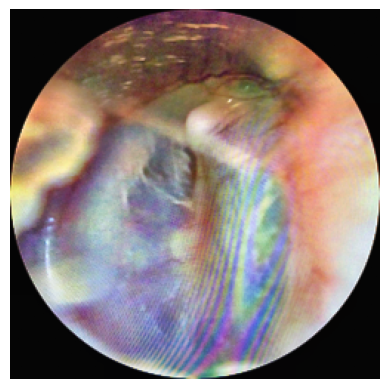

In [10]:
import matplotlib.pyplot as plt

def visualize_image(image_array):
    print("Data type:", image_array.dtype)  # 데이터 타입 확인
    print("Min value:", np.min(image_array))  # 최소값 확인
    print("Max value:", np.max(image_array))  # 최대값 확인

    # 이미지 데이터 정규화 (필요한 경우)
    if np.max(image_array) > 1.0:
        image_array = image_array / 255.0

    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

# 선택된 이미지를 다시 확인
random_index = np.random.randint(0, len(new_x_train))
selected_image = new_x_train[random_index]

# 이미지 시각화 함수 호출
visualize_image(selected_image)